In [255]:
import numpy as np
import pandas as pd
import requests
import datetime
import os
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp

In [256]:
er_r = np.array([0.12, 0.15, 0.20])
covv = np.array([[0.0625, 0.005, 0.0125], [0.005, 0.04, 0.025], [0.0125, 0.025, 0.0625]])
print(er_r[2])
print (cov[1])

0.2
[0.005 0.04  0.025]


In [257]:
#let's find optimal portfolios

def Solver(er, shorting, cov):
    
    weights = cp.Variable(3)

    target = er_r.T @ weights
    #print(portfolio_return)
    #print(weights.value)
    portfolio = cp.quad_form(weights, cov)
    #print(portfolio_risk)
    #m_return = weights.T@cov
    #n_ret = m_return @ weights
    #print(n_ret)
    objective = cp.Minimize(portfolio)##portfolio_return - 0.5 * portfolio_risk)
    if (shorting==True):
        constraints = [cp.sum(weights) == 1, target == er]
    else:
        constraints = [cp.sum(weights) == 1, weights >= 0, target == er]
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    
    return np.round(weights.value, 6)




In [266]:
a = Solver(0.18, True, covv)
print(a)
#print(b)
#print(c)
b = Solver(0.2, False, covv)
print(b)
## solver not working with floats 

[0.083815 0.265896 0.650289]
[0. 0. 1.]


In [259]:
def VarSD(w, cov): 
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    vEr = w1*er_r[0] + w2*er_r[1] + w3*er_r[2]
    ####
    # this part is not working, doesn't scale up # 
    sd1 = 0 
    for i in range(3):
        for j in range (3):
            sd1 += w[i]*w[j]*cov[i][j]
    #####
    
    sd1 = w1*w1*cov[0][0] + w1*w2*cov[0][1] + w1*w3*cov[0][2]
    sd2 = w2*w1*cov[1][0] + w2*w2*cov[1][1] + w2*w3*cov[1][2]
    sd3 = w3*w1*cov[2][0] + w3*w2*cov[2][1] + w3*w3*cov[2][2]
    
    sd = np.sqrt(sd1+sd2+sd3)
    
    return sd1, sd, vEr

In [260]:
e1,s1, er1 = VarSD([0.5,0.3,0.2], covv)
e2, s2, er2 = VarSD(a, covv)
print(e1, s1, er1)
print(e2,s2, er2)

0.017625000000000002 0.16948451256678293 0.14500000000000002
0.019169234664832505 0.18634759684447907 0.12000000999999999


In [261]:
print(int(min(er_r)*100))

12


We have two optimal points of the efficent frontier solved with excel 

In [262]:
wA = []


In [263]:
def generateDB(short):
    sigma = []
    er = []
    eRMax = 300
    eRmin = 0
    if ( not short):
        eRMax = int(max(er_r)*1000)
        eRmin = int(min(er_r)*1000) 
    for j in range (eRmin,eRMax,1):
        i = j/1000
        a = Solver(i, short, covv)
        er.append(i)
        wA.append(a)
        s1, s2, s3 = VarSD(a, covv)
        sigma.append( s2 )

#print (er, sigma)
#print(wA)
    d = {'sigma': sigma, 'Er':er}
    db = pd.DataFrame(data=d)
    return db

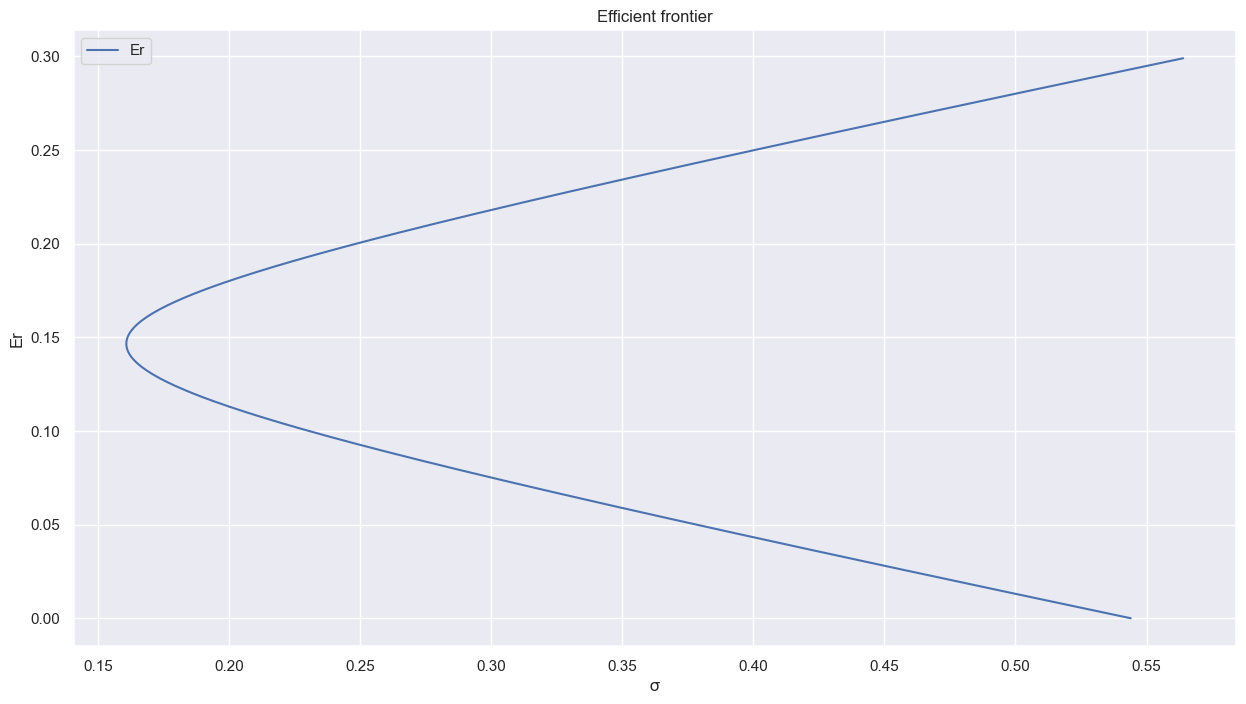

In [264]:
db1 = generateDB(True)
db1.plot(x='sigma', y='Er', kind='line')
plt.title("Efficient frontier")
plt.xlabel("σ")
plt.ylabel("Er")
plt.show()

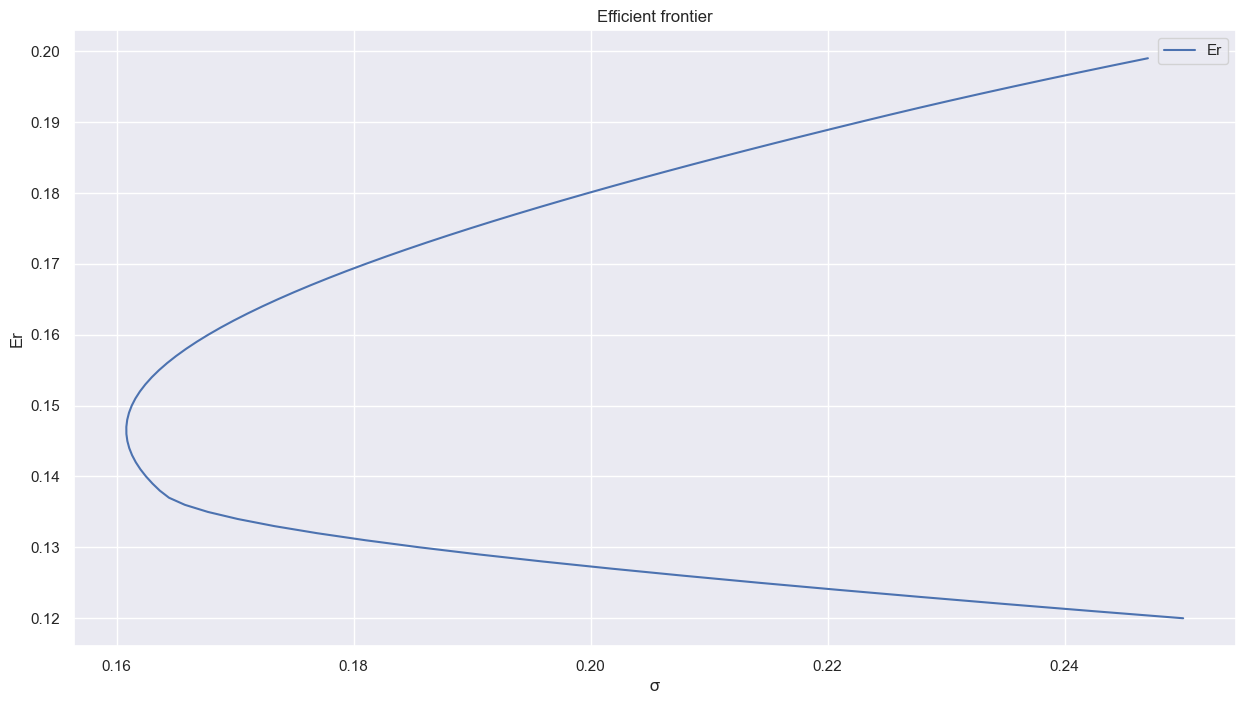

In [265]:
db2 = generateDB(False)
db2.plot(x='sigma', y='Er', kind='line')
plt.title("Efficient frontier")
plt.xlabel("σ")
plt.ylabel("Er")
plt.show()